In [1]:
import numpy as np
import pprint
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *

%load_ext autoreload
%autoreload 2

# Load data from xdf file

From the Unicorn Stream
- `eeg_data`: the 8 channel raw eeg data
- `eeg_timestamps`: timestamp for each eeg sample
- `fs`: the sampling frequency

From the Open Vibe Marker Stream
- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event


In [2]:
DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

dataset = EEG_Dataset(DATA_FILE)

Data succesfullly loaded from data/Sandra_MI_1h.xdf


In [3]:
# Extract the EEG data
eeg_data = dataset.eeg_data
eeg_timestamps = dataset.eeg_timestamps
fs = dataset.fs

print(f"EEG data shape: {eeg_data.shape}")
print(f'Sampling Frequency: {fs}')

# Extract the marker stream data
event_codes = dataset.event_codes
event_labels = dataset.event_labels
label2code = dataset.label2code
print(f'Total number of events: {event_codes.shape[0]}')
pprint.pprint(f'Label->Code: \n{label2code}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for right MI: {label2code["imagery_handR"]}')
print(f'Count left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Count right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

EEG data shape: (8, 1023780)
Sampling Frequency: 250
Total number of events: 1213
('Label->Code: \n'
 "{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, "
 "'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7}")
Event code for left MI: 7
Event code for right MI: 5
Count left MI events: 200
Count right MI events: 200


# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [4]:
eeg_timestamps, event_timestamps, event_timeseries = dataset.build_event_timeseries()

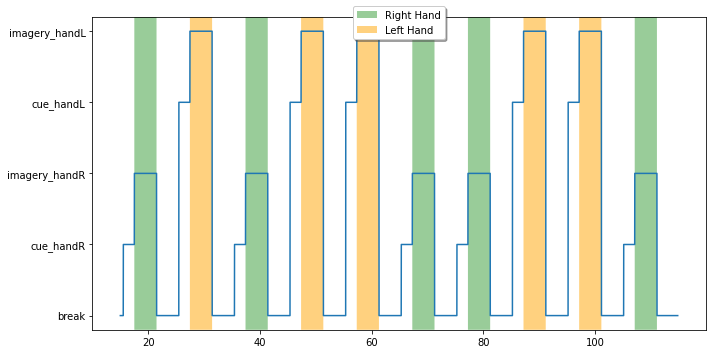

In [5]:
visualise.plot_events(
    eeg_timestamps,
    event_timeseries,
    fs,
    label2code
)

# Preprocess EEG data

## 1. Rereference the EEG data

In [6]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## 2. Filter EEG data

In [7]:
lf = 8
hf = 16
nf = 50
lf_b = 12.5 #beta band
hf_b = 30

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

# bp for beta band
eeg_notched_bp_b = preprocess.bandpass(eeg_notched, lf=lf_b, hf=hf_b, fs=fs, ftype='butter')

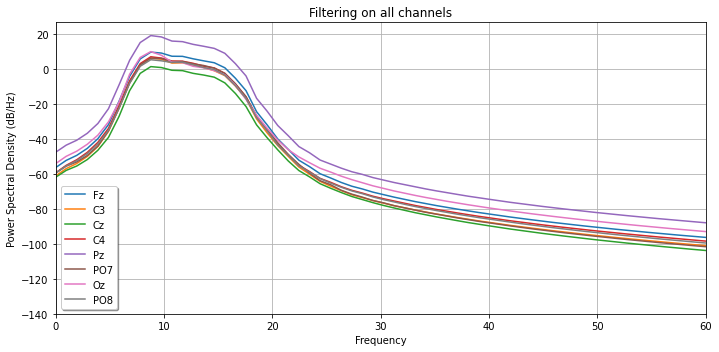

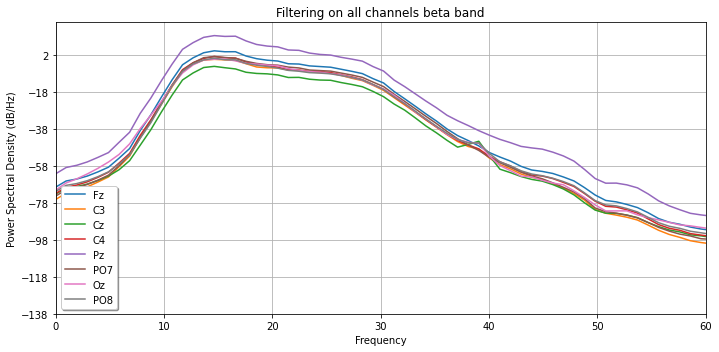

In [8]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
# plt.show()

# beta band 
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels beta band')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp_b[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

## 3. Normalise EEG data

In [9]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)
# beta
eeg_notched_bp_norm_b = preprocess.normalise_eeg(eeg_notched_bp_b)

# Inspect EEG data with markers

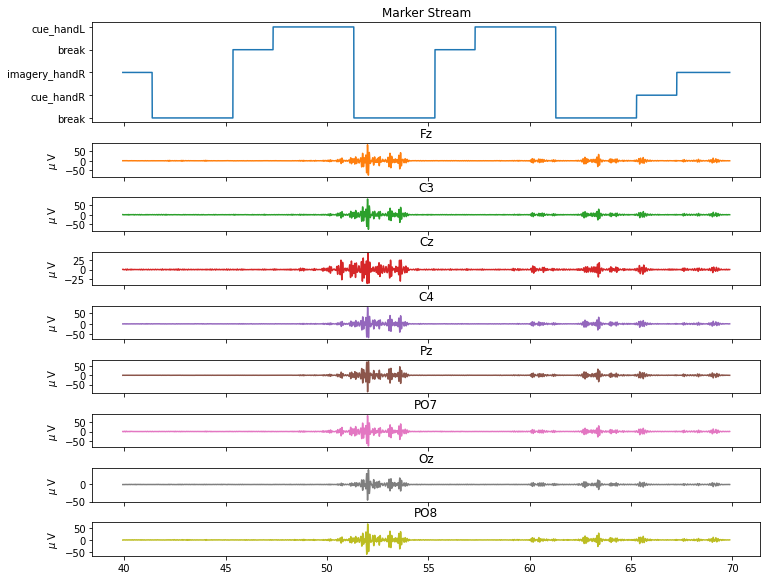

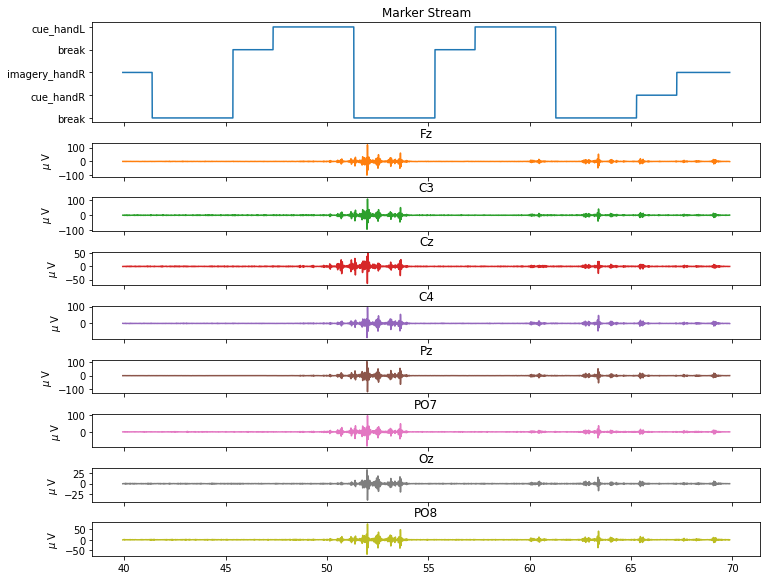

In [10]:
# visualise.plot_all() should be modified for the right name on the left
visualise.plot_all(
    eeg_timestamps=eeg_timestamps, 
    event_time_series=event_timeseries, 
    eeg_data=eeg_notched_bp_norm, 
    event_labels=event_labels,
    fs=fs,
    start_time=40
)
# beta
visualise.plot_all(
    eeg_timestamps=eeg_timestamps, 
    event_time_series=event_timeseries, 
    eeg_data=eeg_notched_bp_norm_b, 
    event_labels=event_labels,
    fs=fs,
    start_time=40
)

# Split into trials

In [13]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# beta band
EEG_b = eeg_notched_bp_norm_b.copy()


# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Sample rate: 250
Number of EEG channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

Number of classes: 2
Class labels: ['imagery_handL', 'imagery_handR']

Number of events: 1213
All event codes: [0 1 2 3 4 5 6 7]
Class codes: [7, 5]


In [14]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)
# beta
trials_b = get_trials(
    eeg_data=EEG_b,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')
# beta
for key, val in trials_b.items():
    print(f'{key}: {val.shape}')

imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)
imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)


# Some statistical Analysis to remove noisy trials

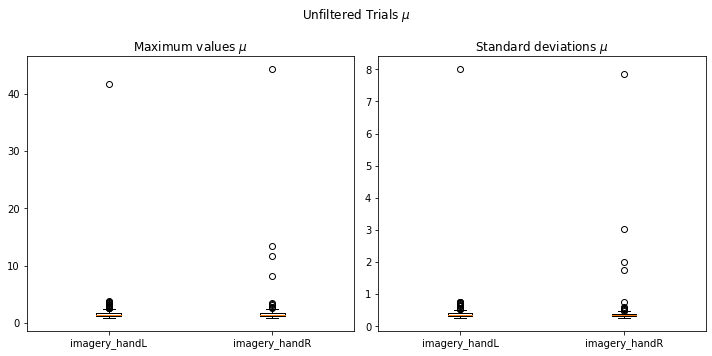

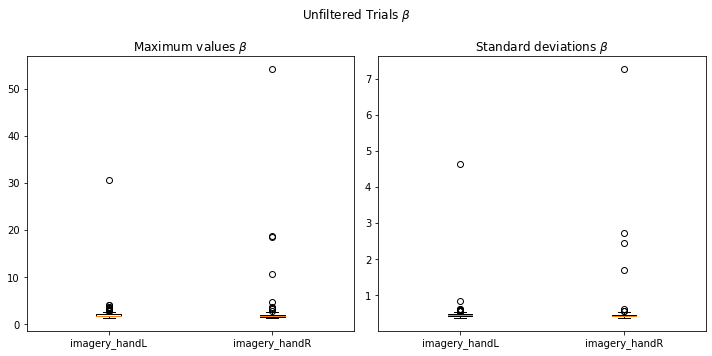

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Unfiltered Trials $\mu$')

axs[0].set_title(r'Maximum values $\mu$')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title(r'Standard deviations $\mu$')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
# plt.show()

# beta
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Unfiltered Trials $\beta$')

axs[0].set_title(r'Maximum values $\beta$')
axs[0].boxplot([ trials_b[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title(r'Standard deviations $\beta$')
axs[1].boxplot([ trials_b[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

In [17]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

# beta
upperlimit_max_b = {}
for cl in classes:
    upperlimit_max_b[cl] = np.percentile(trials_b[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std_b = {}
for cl in classes:
    upperlimit_std_b[cl] = np.percentile(trials_b[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std_b

{'imagery_handL': 0.7132679819307038, 'imagery_handR': 0.6967578859735293}

In [32]:
# take out everything from data_util.get_good_trials 
classes = list(trials.keys())
good_trials = {}
good_trials_b = {}

for cl, nsamples in zip(classes, class_nsamples):
    good_trials[cl] = np.zeros((nchannels, nsamples,1))
    good_trials_b[cl] = np.zeros((nchannels, nsamples,1))

    ntrials = trials[classes[0]].shape[2]

for trial in range(ntrials):

    for cl in classes:
        eeg_sample = trials[cl][:,:,trial]
        eeg_sample_b = trials_b[cl][:,:,trial]
        # take alpha as main condition
        if (eeg_sample.std(axis = (0,1)) < upperlimit_std[cl] and 
            eeg_sample.max(axis = (0,1)) < upperlimit_max[cl]):
            good_trials[cl] = np.concatenate(
                [good_trials[cl], np.expand_dims(eeg_sample, -1)], 
                axis=2
            )
            good_trials_b[cl] = np.concatenate(
                [good_trials_b[cl], np.expand_dims(eeg_sample_b, -1)], 
                axis=2
            )

for cl in classes:
        good_trials[cl] = good_trials[cl][:,:,1:]
        good_trials_b[cl] = good_trials_b[cl][:,:,1:]

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')
    print(f'beta {cl} has {good_trials_b[cl].shape} non noisy trials')


imagery_handL has (8, 500, 187) non noisy trials
beta imagery_handL has (8, 500, 187) non noisy trials
imagery_handR has (8, 500, 190) non noisy trials
beta imagery_handR has (8, 500, 190) non noisy trials


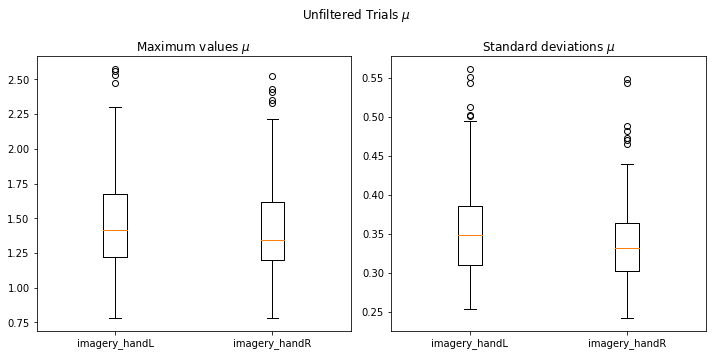

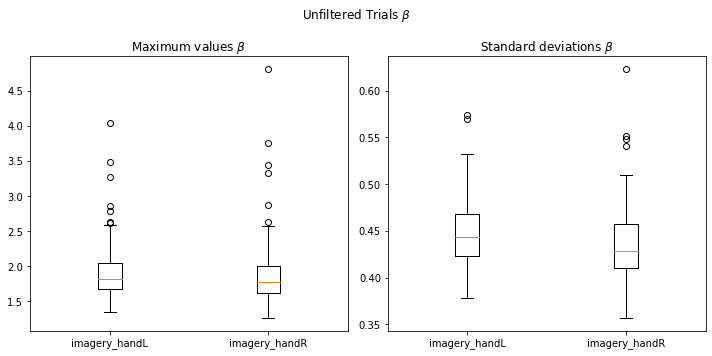

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Unfiltered Trials $\mu$')

axs[0].set_title(r'Maximum values $\mu$')
axs[0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title(r'Standard deviations $\mu$')
axs[1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
# plt.show()

# beta
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Unfiltered Trials $\beta$')

axs[0].set_title(r'Maximum values $\beta$')
axs[0].boxplot([ good_trials_b[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title(r'Standard deviations $\beta$')
axs[1].boxplot([ good_trials_b[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

# Analysis

In [23]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', classes)
print('Class codes:', class_codes)
print('Number of classes:', nclasses)

cl0 = classes[0]
cl1 = classes[1]

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


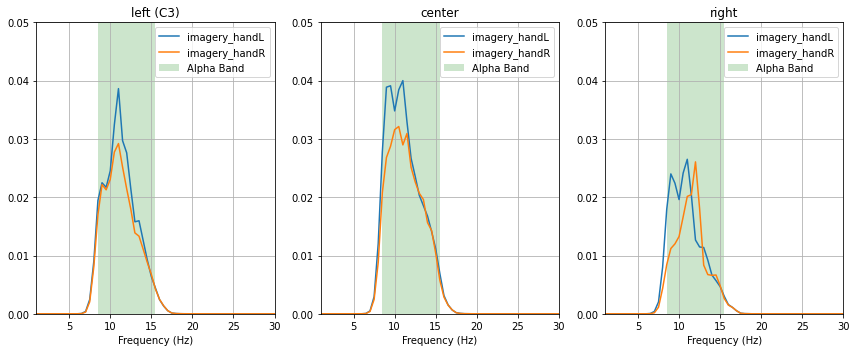

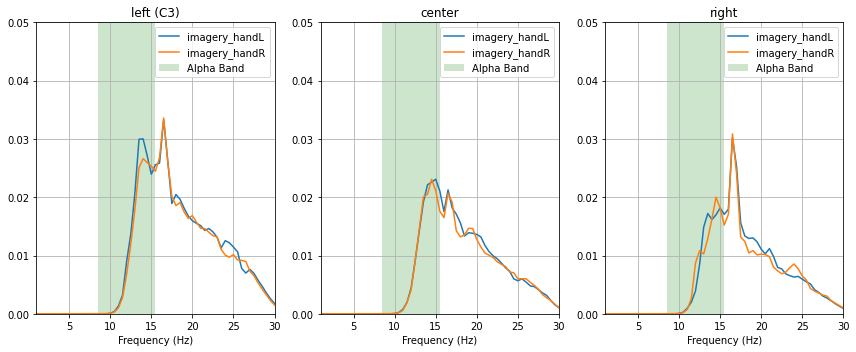

In [24]:
# plot_psd green fill isssue
trials_PSD = {}
trials_PSD_b = {}
for cl in classes:
    psd, freqs, = analysis.psd(good_trials[cl], nchannels, class_nsamples[0], fs)
    trials_PSD[cl] = psd

# beta
    psd_b, freqs, = analysis.psd(good_trials_b[cl], nchannels, class_nsamples[0], fs)
    trials_PSD_b[cl] = psd_b

analysis.plot_psd(
    trials_PSD,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05   #0.05 for normalised data and 1 for not normalised
)

# beta
analysis.plot_psd(
    trials_PSD_b,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05   #0.05 for normalised data and 1 for not normalised
)

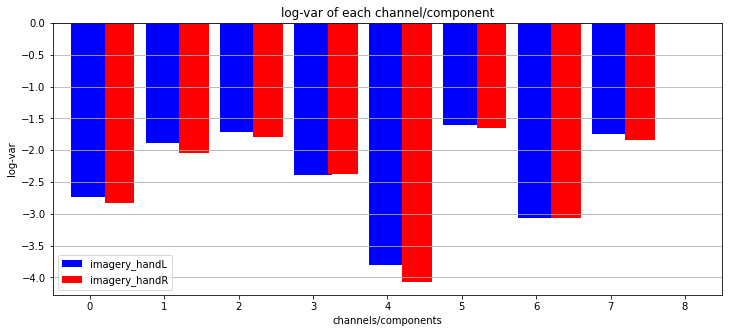

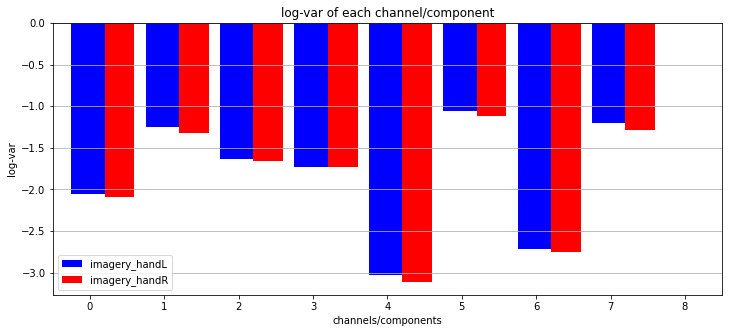

In [25]:
trials_logvar = {}
for cl in classes:
    trials_logvar[cl] = analysis.logvar(good_trials[cl])

analysis.plot_logvar(trials_logvar, classes)

# beta
trials_logvar_b = {}
for cl in classes:
    trials_logvar_b[cl] = analysis.logvar(good_trials_b[cl])

analysis.plot_logvar(trials_logvar_b, classes)

### CSP
Using CSP generates components which are easier to classify than the channels. 

Instead of 8 channels, we now have 8 mixtures of channels, called components. They are the result of 8 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot.

Shape for class imagery_handL after csp: (8, 500, 187)
Shape for class imagery_handR after csp: (8, 500, 190)
Shape for class imagery_handL after logvar: (8, 187)
Shape for class imagery_handR after logvar: (8, 190)
beta Shape for class imagery_handL after csp: (8, 500, 187)
beta Shape for class imagery_handR after csp: (8, 500, 190)
beta Shape for class imagery_handL after logvar: (8, 187)
beta Shape for class imagery_handR after logvar: (8, 190)


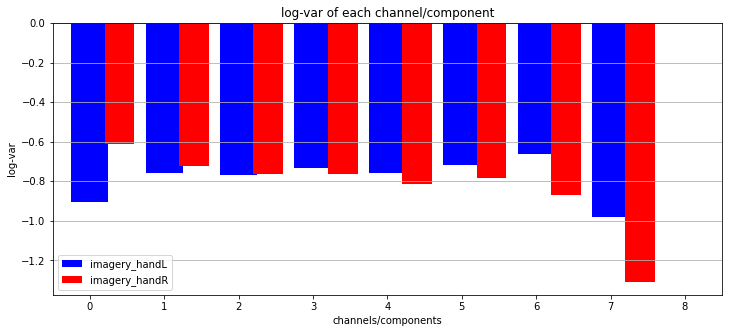

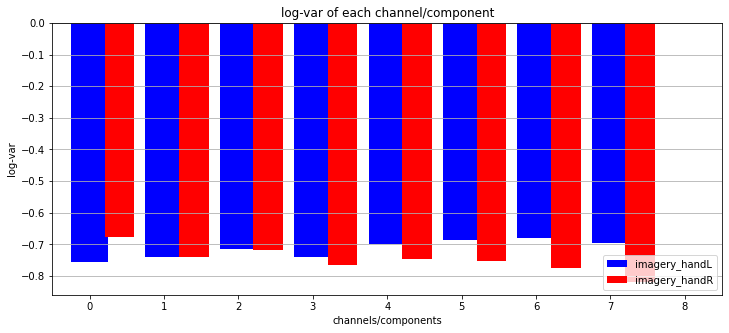

In [37]:
csp = preprocess.CSP(good_trials, classes, class_nsamples[0], nchannels)
trials_csp = csp.get_csp_trials()

for cl in classes:
    print(f'Shape for class {cl} after csp: {trials_csp[cl].shape}')

trials_csp_logvar = {}
for cl in classes:
    trials_csp_logvar[cl] = analysis.logvar(trials_csp[cl])
    print(f'Shape for class {cl} after logvar: {trials_csp_logvar[cl].shape}')

analysis.plot_logvar(trials_csp_logvar, classes)

# beta
csp_b = preprocess.CSP(good_trials_b, classes, class_nsamples[0], nchannels)
trials_csp_b = csp_b.get_csp_trials()

for cl in classes:
    print(f'beta Shape for class {cl} after csp: {trials_csp_b[cl].shape}')

trials_csp_logvar_b = {}
for cl in classes:
    trials_csp_logvar_b[cl] = analysis.logvar(trials_csp_b[cl])
    print(f'beta Shape for class {cl} after logvar: {trials_csp_logvar_b[cl].shape}')

analysis.plot_logvar(trials_csp_logvar_b, classes)

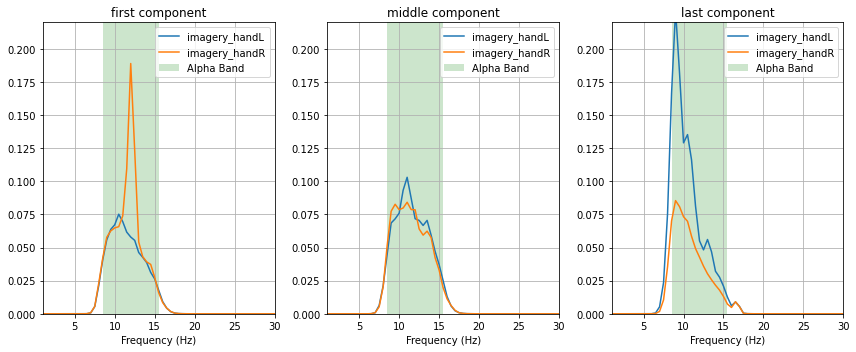

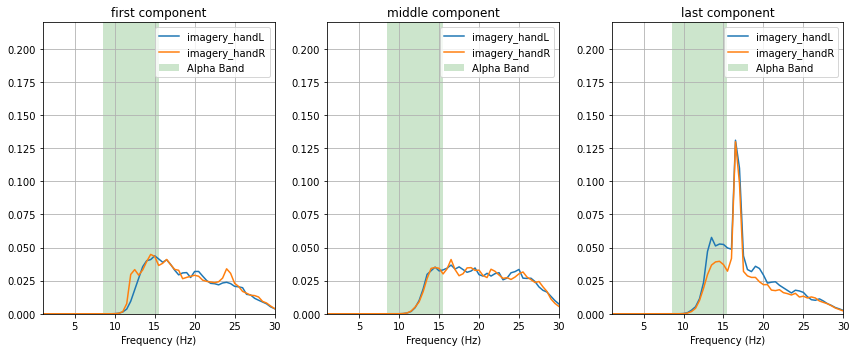

In [33]:
trials_PSD = {}
for cl in classes:
    psd, freqs, = analysis.psd(trials_csp[cl], nchannels, class_nsamples[0], fs)
    trials_PSD[cl] = psd

analysis.plot_psd(
    trials_PSD,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)

# beta
trials_PSD_b = {}
for cl in classes:
    psd_b, freqs, = analysis.psd(trials_csp_b[cl], nchannels, class_nsamples[0], fs)
    trials_PSD_b[cl] = psd_b

analysis.plot_psd(
    trials_PSD_b,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)

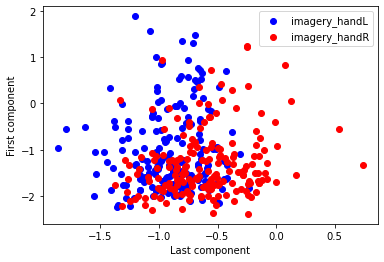

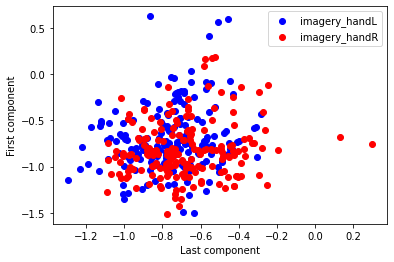

In [34]:
analysis.plot_scatter(trials_csp_logvar[cl0], trials_csp_logvar[cl1], classes)
# beta
analysis.plot_scatter(trials_csp_logvar_b[cl0], trials_csp_logvar_b[cl1], classes)

## LDA

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.metrics import confusion_matrix

In [45]:
# H-PARAMS
nfolds = 5                              # Number of folds
components = np.array([0,-1])           # Select components as features for classification


# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]


# Places to plot/view the results
# fig, axs = plt.subplots(1,5, figsize=(14,4), sharex=True, sharey=True)
# fig.text(0.5, 0.001, 'Last Component', ha='center')
# fig.text(0.001, 0.5, 'First Component', va='center', rotation='vertical')
accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}
    # beta
    train_b = {}
    test_b = {}
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        # beta
        train_b[cl] = np.concatenate(
            [good_trials_b[cl][:,:,:i*ntest], 
            good_trials_b[cl][:,:,(i+1)*ntest:]], axis=2)
        
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]
        # beta
        test_b[cl] = good_trials_b[cl][:,:,i*ntest:(i+1)*ntest]
        # print(f'{cl} train shape: {train[cl].shape}')
        # print(f'{cl} test shape: {test[cl].shape}')

    # CSP
    train_csp = preprocess.CSP(train, classes, class_nsamples[0], nchannels)
    train = train_csp.get_csp_trials()
    W = train_csp.get_W()

    test_csp = preprocess.CSP(test, classes, class_nsamples[0], nchannels, W=W)
    test = test_csp.get_csp_trials()

    for cl in classes:
        train[cl] = train[cl][components,:,:]
        test[cl] = test[cl][components,:,:]
        
        # print(f'CSP ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')
    # beta
    train_csp_b = preprocess.CSP(train_b, classes, class_nsamples[0], nchannels)
    train_b = train_csp_b.get_csp_trials()
    W_b = train_csp_b.get_W()

    test_csp_b = preprocess.CSP(test_b, classes, class_nsamples[0], nchannels, W=W_b)
    test_b = test_csp_b.get_csp_trials()

    for cl in classes:
        train_b[cl] = train_b[cl][components,:,:]
        test_b[cl] = test_b[cl][components,:,:]

    # Logvar
    for cl in classes:
        train[cl] = analysis.logvar(train[cl])
        test[cl] = analysis.logvar(test[cl])
        # print(f'Logvar ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')
    for cl in classes:
        train_b[cl] = analysis.logvar(train_b[cl])
        test_b[cl] = analysis.logvar(test_b[cl])
    for cl in classes:
        train[cl] = np.concatenate((train[cl], train_b[cl]), axis = 0)
        test[cl] = np.concatenate((test[cl], test_b[cl]), axis = 0)
    # Train LDA

    W,b = train_lda(train[cl0].T, train[cl1].T)

    # # Scatterplot 
    # for cl, col in zip(classes, ['r', 'b']):
    #     axs[i].scatter(train[cl][0,:], train[cl][-1,:], color=col)
    # # Calculate decision boundary (x,y)
    # x = np.arange(-3, 2, 0.1)
    # y = (b - W[0]*x) / W[1]
    # # Plot the decision boundary
    # axs[i].plot(x,y, linestyle='--', linewidth=2, color='k')
    # axs[i].set_xlim(-2.5, 2)
    # axs[i].set_ylim(-3, 2)
    # axs[i].set_title(f'Fold {i+1}')


    # Print confusion matrix
    conf = np.array([
        [(apply_lda(test[cl0], W, b) == 1).sum(), 
        (apply_lda(test[cl1], W, b) == 1).sum()],
        [(apply_lda(test[cl0], W, b) == 2).sum(), 
        (apply_lda(test[cl1], W, b) == 2).sum()],
    ])

    confusion_matrices[i] = conf
    accuracies[i] = np.sum(np.diag(conf)) / float(np.sum(conf))


# plt.tight_layout()
# plt.show()

(4, 150)
(4, 37)
(4, 150)
(4, 37)
(4, 150)
(4, 37)
(4, 150)
(4, 37)
(4, 150)
(4, 37)


In [43]:
visualise.print_results(classes, accuracies, confusion_matrices)

Accuracy	True imagery_handL	False imagery_handL	False imagery_handR	True imagery_handR
--------------------------------------------------------------------------------------------------------------
0.55			22			19			15			19
0.69			21			7			16			31
0.57			23			18			14			20
0.71			29			14			8			24
0.79			26			5			11			33
--------------------------------------------------------------------------------------------------------------
0.66			24.2			12.6			12.8			25.4
--------------------------------------------------------------------------------------------------------------


In [44]:
visualise.print_results(classes, accuracies, confusion_matrices, format='md')

Fold |Accuracy	| True imagery_handL	| False imagery_handL	| False imagery_handR	| True imagery_handR |
--- |--- |--- |--- |--- |--- |
Fold 0 | 0.55		| 22		| 19		| 15		| 19 |
Fold 1 | 0.69		| 21		| 7		| 16		| 31 |
Fold 2 | 0.57		| 23		| 18		| 14		| 20 |
Fold 3 | 0.71		| 29		| 14		| 8		| 24 |
Fold 4 | 0.79		| 26		| 5		| 11		| 33 |
Average |0.66		| 24.2		| 12.6		| 12.8		| 25.4 |


## sklearn

In [58]:
# H-PARAMS
nfolds = 5                              # Number of folds
components = np.array([0,-1])           # Select components as features for classification

min_dim = min(good_trials[cl0].shape[2], good_trials[cl1].shape[2])
good_trials[cl0] = good_trials[cl0][:,:,0:min_dim]
good_trials[cl1] = good_trials[cl1][:,:,0:min_dim]
# beta
min_dim = min(good_trials_b[cl0].shape[2], good_trials_b[cl1].shape[2])
good_trials_b[cl0] = good_trials_b[cl0][:,:,0:min_dim]
good_trials_b[cl1] = good_trials_b[cl1][:,:,0:min_dim]

# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]

accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}
    # beta
    train_b = {}
    test_b = {}
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        # beta
        train_b[cl] = np.concatenate(
            [good_trials_b[cl][:,:,:i*ntest], 
            good_trials_b[cl][:,:,(i+1)*ntest:]], axis=2)
        
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]
        # beta
        test_b[cl] = good_trials_b[cl][:,:,i*ntest:(i+1)*ntest]
        # print(f'{cl} train shape: {train[cl].shape}')
        # print(f'{cl} test shape: {test[cl].shape}')

    # CSP
    train_csp = preprocess.CSP(train, classes, class_nsamples[0], nchannels)
    train = train_csp.get_csp_trials()
    W = train_csp.get_W()

    test_csp = preprocess.CSP(test, classes, class_nsamples[0], nchannels, W=W)
    test = test_csp.get_csp_trials()

    for cl in classes:
        train[cl] = train[cl][components,:,:]
        test[cl] = test[cl][components,:,:]
        
        # print(f'CSP ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')
    # beta
    train_csp_b = preprocess.CSP(train_b, classes, class_nsamples[0], nchannels)
    train_b = train_csp_b.get_csp_trials()
    W_b = train_csp_b.get_W()

    test_csp_b = preprocess.CSP(test_b, classes, class_nsamples[0], nchannels, W=W_b)
    test_b = test_csp_b.get_csp_trials()

    for cl in classes:
        train_b[cl] = train_b[cl][components,:,:]
        test_b[cl] = test_b[cl][components,:,:]

    # Logvar
    for cl in classes:
        train[cl] = analysis.logvar(train[cl])
        test[cl] = analysis.logvar(test[cl])
        # print(f'Logvar ({cl}) train: {train[cl].shape}, test: {test[cl].shape}')
    for cl in classes:
        train_b[cl] = analysis.logvar(train_b[cl])
        test_b[cl] = analysis.logvar(test_b[cl])
    # concatenate logvar results of both beta and alpha as new training and testing set 

    for cl in classes:
        train[cl] = np.concatenate((train[cl], train_b[cl]), axis = 0)
        test[cl] = np.concatenate((test[cl], test_b[cl]), axis = 0)
        # print(train[cl].shape)
        # print(test[cl].shape)
    # Train LDA
    # Train
    
    train[cl0] = train[cl0].T
    test[cl0] = test[cl0].T
    train[cl1] = train[cl1].T
    test[cl1] = test[cl1].T

    X_cl0 = train[cl0]
    y_cl0 = np.zeros(X_cl0.shape[0])
    X_cl1 = train[cl1]
    y_cl1 = np.ones(X_cl0.shape[0])

    X_train = np.concatenate([X_cl0, X_cl1], axis=0)
    y_train = np.concatenate([y_cl0, y_cl1], axis=0)

    print(X_train.shape, y_train.shape)

    # Test
    X_cl0 = test[cl0]
    y_cl0 = np.zeros(X_cl0.shape[0])
    X_cl1 = test[cl1]
    y_cl1 = np.ones(X_cl0.shape[0])

    X_test = np.concatenate([X_cl0, X_cl1], axis=0)
    y_test = np.concatenate([y_cl0, y_cl1], axis=0)
    print(X_test.shape, y_test.shape)

    clf_lda = skLDA()
    clf_lda.fit(X_train, y_train)

    ypred = clf_lda.predict(X_test)
    # Print confusion matrix
    # conf = np.array([
    #     [(apply_lda(test[cl0], W, b) == 1).sum(), 
    #     (apply_lda(test[cl1], W, b) == 1).sum()],
    #     [(apply_lda(test[cl0], W, b) == 2).sum(), 
    #     (apply_lda(test[cl1], W, b) == 2).sum()],
    # ])

    confusion_matrices[i] = confusion_matrix(y_test, ypred)
    accuracies[i] = np.sum(ypred == y_test) / ypred.size



(300, 4) (300,)
(74, 4) (74,)
(300, 4) (300,)
(74, 4) (74,)
(300, 4) (300,)
(74, 4) (74,)
(300, 4) (300,)
(74, 4) (74,)
(300, 4) (300,)
(74, 4) (74,)


In [59]:
visualise.print_results(classes, accuracies, confusion_matrices)

Accuracy	True imagery_handL	False imagery_handL	False imagery_handR	True imagery_handR
--------------------------------------------------------------------------------------------------------------
0.55			22			15			18			19
0.70			21			16			6			31
0.57			23			14			18			19
0.72			29			8			13			24
0.80			26			11			4			33
--------------------------------------------------------------------------------------------------------------
0.67			24.2			12.8			11.8			25.2
--------------------------------------------------------------------------------------------------------------


In [60]:
visualise.print_results(classes, accuracies, confusion_matrices, format='md')

Fold |Accuracy	| True imagery_handL	| False imagery_handL	| False imagery_handR	| True imagery_handR |
--- |--- |--- |--- |--- |--- |
Fold 0 | 0.55		| 22		| 15		| 18		| 19 |
Fold 1 | 0.70		| 21		| 16		| 6		| 31 |
Fold 2 | 0.57		| 23		| 14		| 18		| 19 |
Fold 3 | 0.72		| 29		| 8		| 13		| 24 |
Fold 4 | 0.80		| 26		| 11		| 4		| 33 |
Average |0.67		| 24.2		| 12.8		| 11.8		| 25.2 |
